# Bjerknes Compensation in iHESP PI-CTRL 
Model and experiment description: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020MS002298

Note that the first 150 years of PI-CTRL exhibit an adjustment of the upper ocean due to hardware issues during the model run. 

In [1]:
import netCDF4 as nc
from netCDF4 import Dataset

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import xarray as xr

from scipy import signal
from scipy import stats

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn import linear_model

# Methods

In [5]:
# directory paths
atmdir = "/global/project/projectdirs/m1199/iHESP/Atmosphere/"
ocndir = "/global/project/projectdirs/m1199/iHESP/Ocean/"

# in:    t (1 to 50) 
# out:   string corresponding to date range 
def getTimeRange(t):
    initial = (t + 1) * 1000 + 1 if t != 1 else (t + 1) * 1000 + 101
    final = (t + 1) * 1000 + 912
    return "00" + str(initial) + "-00" + str(final) if initial < 10000 else "0" + str(initial) + "-0" + str(final)

# in:    var (str)
#        directory (atmdir or ocndir)
#        t (1 to 50) corresponding to decade
#        getDataset 
#        domain 
# out:   data

# todo: add option to revert back to full spatial dataset

def getData(var, directory, t, lats=[0,257], lons=[0,512], getDataset=False):
    filename = "B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.cam.h0."+var+"."+getTimeRange(1)+".gr.nc"
    data = xr.open_dataset(directory+var+"/"+filename).variables[var][:,lats[0]:lats[1],lons[0]:lons[1]] 
    if t == "all":
        for i in range(49):
            filename = "B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.cam.h0."+var+"."+getTimeRange(i+1)+".gr.nc"
            # append to time axis
            data = np.append(data, xr.open_dataset(directory+var+"/"+filename).
                             variables[var][:,lats[0]:lats[1],lons[0]:lons[1]], axis=0)
        return data 
    else: 
        filename = "B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.cam.h0."+var+"."+getTimeRange(t)+".gr.nc"
        data = xr.open_dataset(directory+var+"/"+filename)

        return data if getDataset else data.variables[var][:,lats[0]:lats[1],lons[0]:lons[1]]
    
# takes running mean for first axis 
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0, axis=0), axis=0) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

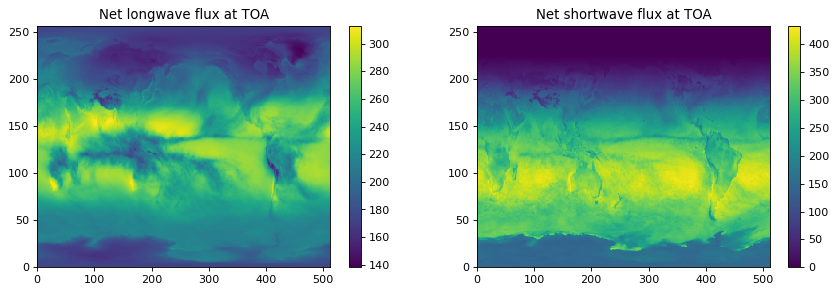

In [4]:
# sign convention: 
# positive longwave is net upwards 
# positive shortwave is net downwards 

flnt = getData("FLNT", atmdir, 1)
fsnt = getData("FSNT", atmdir, 1)

figure(figsize=(13, 4), dpi=80)

plt.subplot(1,2,1)
plt.pcolormesh(flnt[0,:,:])
plt.title('Net longwave flux at TOA')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(fsnt[0,:,:])
plt.title('Net shortwave flux at TOA')
plt.colorbar()

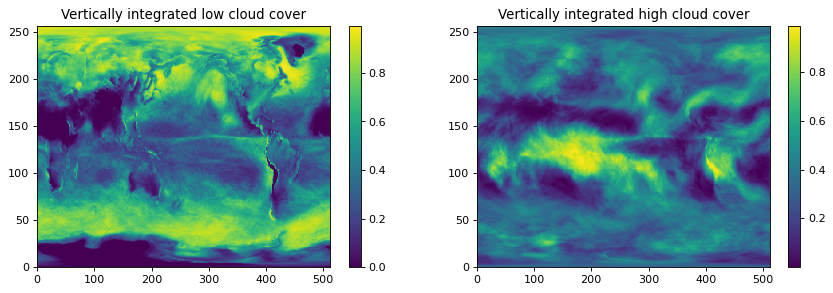

In [5]:
cldlow = getData("CLDLOW", atmdir, 1)
cldhgh = getData("CLDHGH", atmdir, 1)

figure(figsize=(13, 4), dpi=80)

plt.subplot(1,2,1)
plt.pcolormesh(cldlow[0,:,:])
plt.title('Vertically integrated low cloud cover')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(cldhgh[0,:,:])
plt.title('Vertically integrated high cloud cover')
plt.colorbar()


# Calculating AHT and BJC
## Latent heat flux snow correction
Here we estimate the total heat flux at the surface and TOA. We add a correction for the latent heat flux due to snowfall as such:

$F_{snow} = \rho_w \Delta H_{fus} (P_{sc} + P_{sl})$

where $P_{sc}$ and $P_{sl}$ are the convective and large-scale snowfall rates respectively (units m/s)

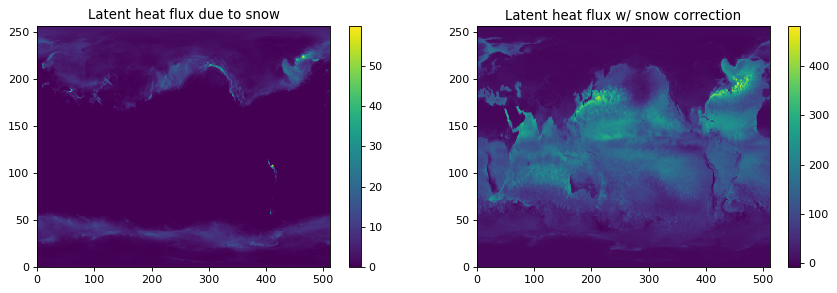

In [127]:
# latent and sensible heat flux
# up is positive (both)
lhfs = getData("LHFLX", atmdir, 1, nhemisphere=False)
shfs = getData("SHFLX", atmdir, 1, nhemisphere=False)

# get snowfall rate 
precsc = getData("PRECSC", atmdir, 1, nhemisphere=False)
precsl = getData("PRECSL", atmdir, 1, nhemisphere=False) 

# calculate the latent heat flux due to snowfall
# rho_w * L_w * (snow rate)
# positive is up
hflxsnow = 1000 * 334000 * (precsl+precsc)

figure(figsize=(13, 4), dpi=80)

plt.subplot(1,2,1)
plt.pcolormesh(hflxsnow[0,:,:])
plt.title('Latent heat flux due to snow')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(lhfs[0,:,:] + hflxsnow[0,:,:])
plt.title('Latent heat flux w/ snow correction')
plt.colorbar()

In [6]:
# get entire timeseries of fluxes to calculate AHT timeseries 
flnt = getData("FLNT", atmdir, "all")
fsnt = getData("FSNT", atmdir, "all")

flns = getData("FLNS", atmdir, "all")
fsns = getData("FSNS", atmdir, "all")

lhfs = getData("LHFLX", atmdir, "all")
shfs = getData("SHFLX", atmdir, "all")

# get snowfall rate 
precsc = getData("PRECSC", atmdir, "all")
precsl = getData("PRECSL", atmdir, "all") 

# calculate the latent heat flux due to snowfall
# rho_w * L_w * (snow rate)
# positive is up
hflxsnow = 1000 * 334000 * (precsc + precsl)

# total fluxes (up is positive)  
fnt = flnt - fsnt 
fns = flns - fsns + lhfs + shfs + hflxsnow

# get lat lon grid 
lat = getData("FLNT", atmdir, 1, getDataset=True).variables["lat"]
lon = getData("FLNT", atmdir, 1, getDataset=True).variables["lon"]
area = getData("FLNT", atmdir, 1, getDataset=True).variables["area"] # solid angle subtended by gridcell

nlat = lat.size
nlon = lon.size

a = 6.3781e6     # radius of the earth in m

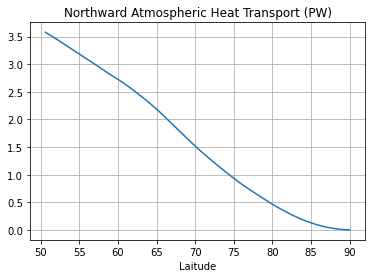

In [37]:
# find the area integrated net flux for each grid cell
fint = (fnt - fns) * area[200:,:].to_numpy() * a**2

fxint = fint.sum(axis=2) # integrate zonally 

aht = np.flip(np.cumsum(np.flip(fxint, axis=1), axis=1), axis=1) # integrate meridionally 

## OHT and AHT

(7/16) Some notes regarding calculated OHT and AHT timeseries: 
- The AHT timeseries in AHT.npy was calculated for only north of 50 deg N
    - there remains a residual because np.cumsum starts from the first value and the zonally integrated flux divergence at the north pole is not zero
    - y = 21 corresponds to 65 deg N
- The OHT timeseries is stored in N_HEAT, which has four fields: time, transport_basin, transport_component, lat 
    - OHT timeseries starts at 0278-01 and ends at 0501-12
    - transport_basin 0: global ocean - marginal seas; 1: Atlantic Ocean + Mediterranean Sea + Labrador Sea + GIN Sea + Arctic Ocean + Hudson Bay + Baltic
    - transport_component 0: Total; 1: Mean; 2: Eddy
    - lat: 347 = 65.06 deg N

## Calculating $r$ for BJC
A Pearson's $r$ is calculated between 10-yr running mean timeseries of AHT and OHT to quantify the BJC. When the monthly timeseries were compared for EY 278 to 501, $r=-0.04$; when the entire annual timeseries were compared, $r=-0.41$. Note that most of this difference is caused by the addition of Experiment Years 21-278 for annual data. 
    

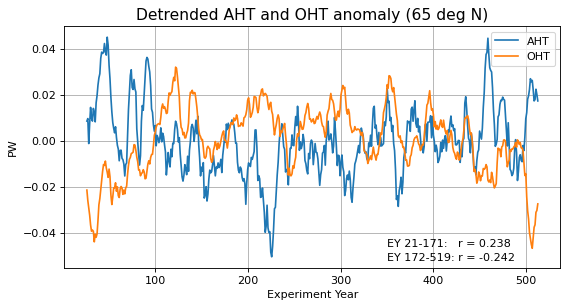

In [62]:
yr_start = 21
yr_end = 518

t_index_start = (yr_start - 21) * 12 
t_index_end = (yr_end - 21) * 12 + 11

movmean_interval = 10 #years

# for time axis
years = np.linspace(yr_start+5, yr_end-5, 489)
years2 = np.linspace(282, 496, 2569)

# get AHT timeseries 
aht_mon = np.load("data/AHT.npy")[:, 21] 
aht_ann = np.zeros(498)
for i in range(498):  # convert AHT to annual mean
    aht_ann[i] = np.mean(aht_mon[i*12:i*12+12])
    
aht_ann_movmean = running_mean(aht_ann[:], movmean_interval)/1e15

# get the full (annual mean) OHT timeseries at 65 deg N
oht_ann = xr.open_dataset(ocndir + "vTFlux_65N.nc").variables['vTFlux_65N'][21:]

# get the monthly OHT timeseries (only yrs 271-501)
n_heat = xr.open_dataset(ocndir+"N_HEAT/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.N_HEAT.027801.050112.nc").variables['N_HEAT']
oht_mon = n_heat[:,1,0,347]
oht_ann_movmean = running_mean(oht_ann, movmean_interval)
oht_mon_movmean = running_mean(oht_mon, 120)

# calculate Pearson's r 
bjcr_sec1 = stats.pearsonr(signal.detrend(aht_ann_movmean[0:150]),signal.detrend(oht_ann_movmean[0:150]))
bjcr_sec2 = stats.pearsonr(signal.detrend(aht_ann_movmean[150:]),signal.detrend(oht_ann_movmean[150:]))

figure(figsize=(8, 4), dpi=80)

plt.plot(years, signal.detrend(aht_ann_movmean), label = "AHT")
plt.plot(years, signal.detrend(oht_ann_movmean), label = "OHT")
plt.grid(True)
plt.title("Detrended AHT and OHT anomaly (65 deg N)", fontsize=14)
plt.xlabel("Experiment Year")
plt.ylabel("PW")
plt.text(350,-0.046, 'EY 21-171:   r = ' + str(np.around(bjcr_sec1[0],3)))
plt.text(350,-0.052, 'EY 172-519: r = ' + str(np.around(bjcr_sec2[0],3)))
plt.legend()

#plt.savefig("figures/OHT_AHT_65N.svg")

## Additional figures for AHT and OHT

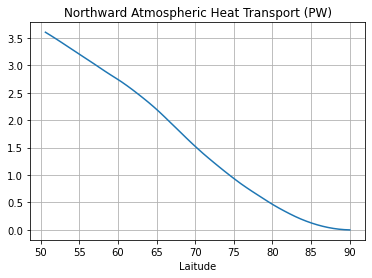

In [211]:
# get lat lon grid 
lat = getData("FLNT", atmdir, 1, getDataset=True).variables["lat"]
lon = getData("FLNT", atmdir, 1, getDataset=True).variables["lon"]
area = getData("FLNT", atmdir, 1, getDataset=True).variables["area"] # solid angle subtended by gridcell

nlat = lat.size
nlon = lon.size

# plot the average for the first nine years 
plt.plot(lat[200:], np.mean(aht[0:108,:], axis=0)/1e15)
plt.title("Northward Atmospheric Heat Transport (PW)")
plt.xlabel("Laitude")
plt.grid(True)

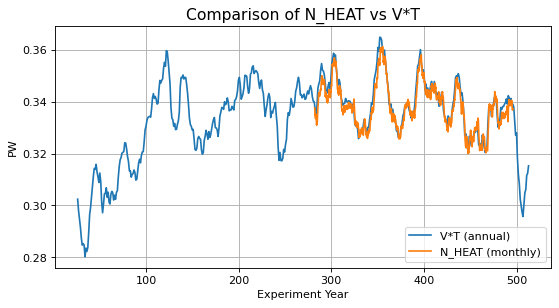

In [65]:
# compare N_HEAT vs V*T calculation
figure(figsize=(8, 4), dpi=80)
plt.plot(years, oht_ann_movmean, label = "V*T (annual)")
plt.plot(years2, oht_mon_movmean, label = "N_HEAT (monthly)")
plt.title("Comparison of N_HEAT vs V*T", fontsize=14)
plt.ylabel("PW")
plt.xlabel("Experiment Year")
plt.legend()
plt.grid(True)

#plt.savefig("figures/OHT_ann_mon_comparison.svg")

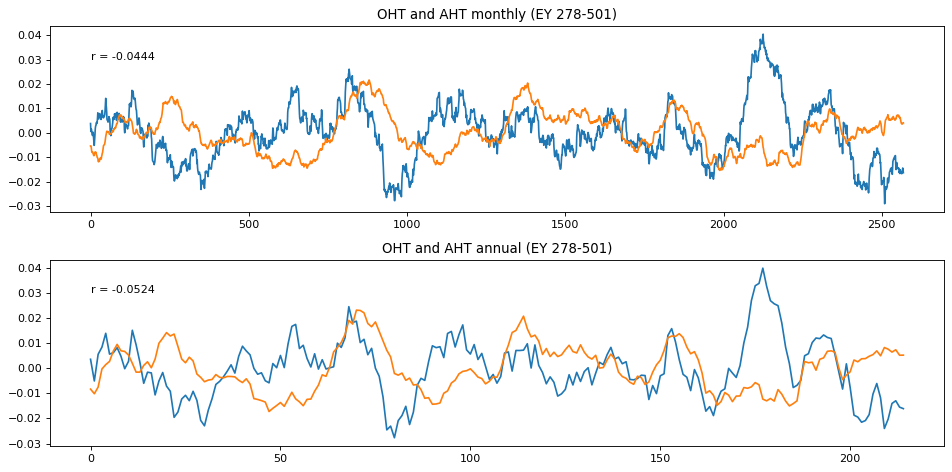

In [69]:
# compare regression of monthly OHT and annual OHT over the same period (278-501)
oht_ann_sect = running_mean(oht_ann[257:481], 10)
aht_ann_sect = running_mean(aht_ann[257:481], 10)/1e15

oht_ann_sect2 = running_mean(oht_ann[0:257], 10)
aht_ann_sect2 = running_mean(aht_ann[0:257], 10)/1e15

oht_mon_sect = running_mean(oht_mon, 120)
aht_mon_sect = running_mean(aht_mon[3084:5772], 120)/1e15

time_axs = np.linspace(0,222,222)
time_axs2 = np.linspace(0,222,2569)

r_bjc_ann = stats.pearsonr(signal.detrend(oht_ann_sect), signal.detrend(aht_ann_sect))
r_bjc_ann2 = stats.pearsonr(signal.detrend(oht_ann_sect2), signal.detrend(aht_ann_sect2))
r_bjc_mon = stats.pearsonr(signal.detrend(oht_mon_sect), signal.detrend(aht_mon_sect))


# plot it 
figure(figsize=(12, 6), dpi=80)

plt.subplot(2,1,1)
plt.plot(signal.detrend(aht_mon_sect))
plt.plot(signal.detrend(oht_mon_sect))
plt.title("OHT and AHT monthly (EY 278-501)", )
plt.text(0, 0.03, "r = "+ str(np.round(r_bjc_mon[0],4)))

plt.subplot(2,1,2)
plt.plot(signal.detrend(aht_ann_sect))
plt.plot(signal.detrend(oht_ann_sect))
plt.title("OHT and AHT annual (EY 278-501)")
plt.text(0, 0.03, "r = "+ str(np.round(r_bjc_ann[0],4)))
plt.tight_layout()

#plt.savefig("figures/OHT_AHT_ann_mon_comparison.svg")

# Sea ice
(7/19) We expect the greatest compensation to occur at the sea ice margin. This is where anomalous OHT generates the greatest response in AHT via modulation of the sea ice layer. Since there is little to no BJC, we first diagnose the sea ice correlation with OHT to see to what extent OHT modulates the ice cover. 

The sea ice fraction is stored in the `ICEFRAC` variable.

In [3]:
icefrac = getData("ICEFRAC", atmdir, "all")

In [16]:
# get annual mean
icefrac_ann = np.load("data/icefrac_ann.npy")

# detrend and take moving mean 
icefrac_ann_movmean = signal.detrend(running_mean(icefrac_ann[150:], 10), axis=0)
nt, nlat, nlon = icefrac_ann_movmean.shape

## Climatology and variability 
(7/21) The HR configuration of CESM1.3 as seen here is known to consistently underestimate sea ice extent (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020MS002298). 

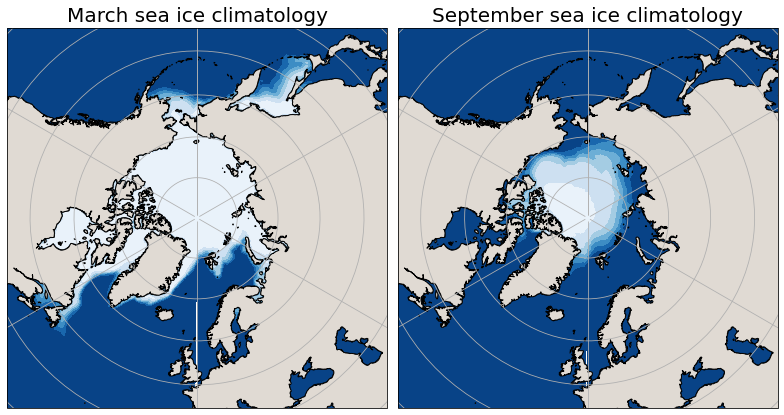

In [80]:
# get sea ice for seasons 
icefrac_mar = np.mean(icefrac.reshape(-1,12,nlat,nlon)[150:,2,:,:], axis=0)
icefrac_sep = np.mean(icefrac.reshape(-1,12,nlat,nlon)[150:,8,:,:], axis=0)

# plot seasonal sea ice climatology 
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(11,8.5))

tan = (224/255, 218/255, 211/255)

axs[0].contourf(lon, lat, icefrac_mar, cmap='Blues_r', transform=ccrs.PlateCarree())
axs[0].set_title("March sea ice climatology", fontsize=20)
axs[0].coastlines()
axs[0].set_extent([-180, 180, 90, 45], ccrs.PlateCarree())
axs[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor=tan))
axs[0].gridlines()

axs[1].contourf(lon, lat, icefrac_sep, cmap='Blues_r', transform=ccrs.PlateCarree())
axs[1].set_title("September sea ice climatology", fontsize=20)
axs[1].coastlines()
axs[1].set_extent([-180, 180, 90, 45], ccrs.PlateCarree())
axs[1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor=tan))
axs[1].gridlines()

fig.tight_layout()
#fig.savefig("figures/si_climatology.svg")

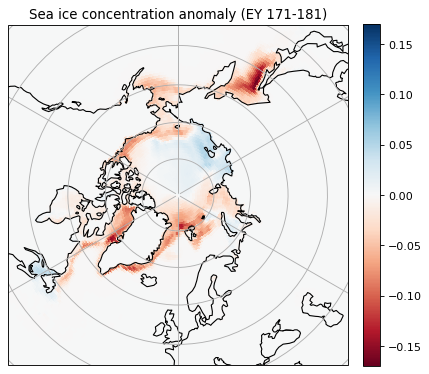

In [77]:
# get lat lon grid
lat = getData("FLNT", atmdir, 1, getDataset=True).variables["lat"]
lon = getData("FLNT", atmdir, 1, getDataset=True).variables["lon"]

figure(figsize=(6,6), dpi=80)

ax = plt.axes(projection=ccrs.NorthPolarStereo())

plt.pcolormesh(lon, lat, icefrac_ann_movmean[150,:,:], cmap='RdBu', transform=ccrs.PlateCarree())
plt.title("Sea ice concentration anomaly (EY 171-181)")
ax.coastlines()
ax.set_extent([-180, 180, 90, 45], ccrs.PlateCarree())
ax.gridlines()
plt.clim(-0.17,0.17)
plt.colorbar(fraction=0.046, pad=0.04)


In [14]:
# get the full (annual mean) OHT timeseries at 65 deg N
oht_ann = xr.open_dataset(ocndir + "vTFlux_65N.nc").variables['vTFlux_65N'][21:]
oht_ann_movmean = running_mean(oht_ann, 10)

# normalize the OHT timeseries
oht_norm = signal.detrend(oht_ann_movmean[150:]/oht_ann_movmean[150:].std(ddof = 1))

nt, nlat, nlon = icefrac_ann_movmean.shape

regr = linear_model.LinearRegression()
regr.fit(oht_norm.reshape(-1,1), icefrac_ann_movmean.reshape(-1, nlat*nlon))
oht_sic_reg = regr.coef_[:,0]
oht_sic_reg = oht_sic_reg.reshape(nlat, nlon)

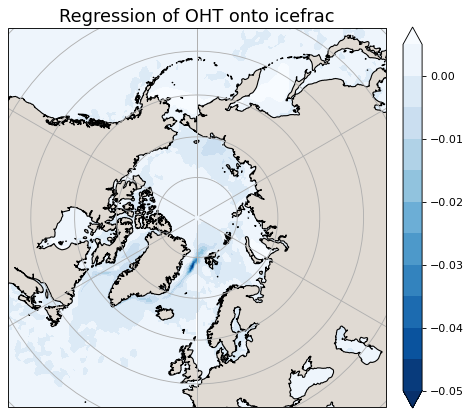

In [78]:
# plot the regression map
lat = getData("FLNT", atmdir, 1, getDataset=True).variables["lat"]
lon = getData("FLNT", atmdir, 1, getDataset=True).variables["lon"]

figure(figsize=(6,6), dpi=80)

tan = (224/255, 218/255, 211/255)

ax = plt.axes(projection=ccrs.NorthPolarStereo())

plt.contourf(lon, lat, oht_sic_reg[:,:], np.arange(-0.05,0.01,.005), 
             extend='both', cmap='Blues_r', transform=ccrs.PlateCarree())
plt.title("Regression of OHT onto icefrac", fontsize=16)
ax.gridlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor=tan))
ax.set_extent([-180, 180, 90, 45], ccrs.PlateCarree())
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()

#plt.savefig("figures/OHT_si_regress.svg")